In [16]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.python.platform.build_info import build_info
from tensorflow.config.experimental import list_physical_devices, VirtualDeviceConfiguration, set_virtual_device_configuration #type:ignore

from tensorflow.keras.regularizers import l2 #type:ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #type:ignore
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, LeakyReLU, AveragePooling2D #type:ignore
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model #type:ignore

from tensorflow.keras.losses import Loss #type:ignore
from tensorflow.keras import backend as K #type:ignore
from tensorflow.keras.losses import CategoricalFocalCrossentropy #type:ignore
from sklearn.utils.class_weight import compute_class_weight

from pathlib import Path
import os
import shutil
import random

In [17]:
params = { 
    'filters': 64,
    'conv_layers': 4,
    'dense_units': 128, 
    'dropout': 0.30, 
    'batch_norm': True, 
    'optimizer': "adam", 
    'lr': 1e-3, 
    'flattening_layers': "GAP2D",
    'random_state': 42
}

In [18]:
current_dir = Path(os.getcwd())

data_dir = current_dir.parent / "data"

train_dir = data_dir / "train"
val_dir = data_dir / "valid"
test_dir = data_dir / "test"

model_name = "Sequential_Model"
checkpoints_dir = current_dir.parent / "checkpoints" / model_name
checkpoints_dir.mkdir(parents=True, exist_ok=True)

checkpoint_file_name = model_name + "-1.h5"

print(f"{'Project Root:':<25}{current_dir.parent}")
print(f"{'Train Directory:':<25}{train_dir}")
print(f"{'Validation Directory:':<25}{val_dir}")
print(f"{'Test Directory:':<25}{test_dir}")
print(f"{'Checkpoints Directory:':<25}{checkpoints_dir}")
print(f"{'Checkpoint File Name:':<25}{checkpoint_file_name}")

Project Root:            c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier
Train Directory:         c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\train
Validation Directory:    c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\valid
Test Directory:          c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\data\test
Checkpoints Directory:   c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\Sequential_Model
Checkpoint File Name:    Sequential_Model-1.h5


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False 
)

Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.


In [20]:
model = tf.keras.models.load_model(str(checkpoints_dir / checkpoint_file_name))

In [21]:
def evaluate_model(model, test_ds, class_names):
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\nTest Results:\nAccuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

    preds = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(preds, axis=1)

    if hasattr(test_ds, 'labels'):
        y_true = test_ds.labels
    else:
        y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    print('\nClassification Report:\n')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    return test_acc, test_loss, y_pred


Test Results:
Accuracy: 0.8138 | Loss: 0.1651
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step


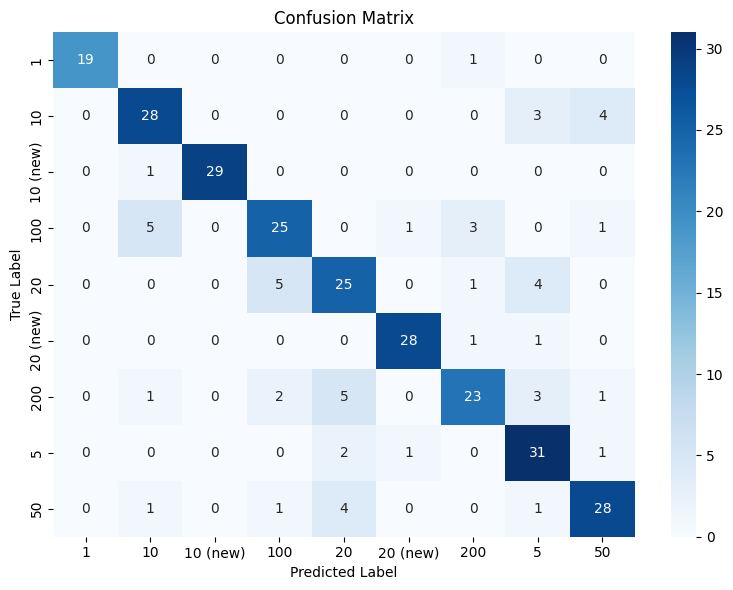


Classification Report:

              precision    recall  f1-score   support

           1     1.0000    0.9500    0.9744        20
          10     0.7778    0.8000    0.7887        35
    10 (new)     1.0000    0.9667    0.9831        30
         100     0.7576    0.7143    0.7353        35
          20     0.6944    0.7143    0.7042        35
    20 (new)     0.9333    0.9333    0.9333        30
         200     0.7931    0.6571    0.7188        35
           5     0.7209    0.8857    0.7949        35
          50     0.8000    0.8000    0.8000        35

    accuracy                         0.8138       290
   macro avg     0.8308    0.8246    0.8258       290
weighted avg     0.8174    0.8138    0.8136       290



In [22]:
test_acc, test_loss, y_pred = evaluate_model(model, test_generator, list(test_generator.class_indices.keys()))

In [23]:
def plot_training_curves(history, test_acc=0):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.axhline(y=test_acc, linestyle='--', color='green', label=f'Test Acc: {test_acc:.2f}')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()